# Session 6. RNN을 활용한 문제 해결, 감성분석

## Part.1 감성분석

### import libraries

#### general libraries

In [1]:
import numpy as np
import os
import time
np.random.seed(1)
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#### libraries for machine learning

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout, Activation, Embedding
from keras.callbacks import TensorBoard, EarlyStopping, CSVLogger, ModelCheckpoint
from keras.utils import plot_model
from keras.preprocessing import sequence
import keras.backend as K

Using TensorFlow backend.


#### libraries for NLP

In [4]:
import collections
import nltk

### Set Accuracy Measure

In [5]:
def binary_PFA(y_true, y_pred, threshold = K.variable(value = 0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    N = K.sum(1 - y_true) 
    FP = K.sum(y_pred - y_pred * y_true)
    return FP / N

def binary_PTA(y_true, y_pred, threshold = K.variable(value = 0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    P = K.sum(y_true)
    TP = K.sum(y_pred * y_true)
    return TP / P

def auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis = 0)
    pfas = tf.stack([binary_PFA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis = 0)
    pfas = tf.concat([tf.ones((1, )), pfas], axis = 0)
    binSizes = -(pfas[1:] - pfas[:-1])
    s = ptas * binSizes
    return K.sum(s, axis = 0)

### Set Data Path

In [6]:
data_path = "./input"

### Download A punkt Package of nltk

In [31]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Package punkt is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

### Read Training Tata & Generate Vocabulary

In [7]:
max_n_tokens = 0 # 문장의 단어를 토큰으로 변환 후 그 수를 저장한 것들 중 최대값
word_frequency = collections.Counter() # 문장내 단어들의 빈도수를 저장할 딕셔너리
n_lines = 0 # 읽은 line의 수를 저장

In [8]:
train_file = open(os.path.join(data_path, "umich-sentiment-train.txt"), 'rb')
# data path에 있는 train data를 바이너리 형태로 읽기
# 감정에 대한 label과 해당 문장으로 구성

In [9]:
for line in train_file:
    label, sentence = line.decode('utf8').strip().split("\t")
    # 한 줄씩 UTF-8의 유니코드로 읽는다
    # strip: 문자열 양쪽에 한 칸 이상의 공백 제거
    # split: () 안의 구분 기호를 통해 구분, {\t: 탭, \n: 줄바꿈, ',', '.', ... }
    words = nltk.word_tokenize(sentence.lower())
    # 읽은 문장의 대문자를 소문자로 바꾸고 토큰화
    if len(words) > max_n_tokens:
        max_n_tokens = len(words)  # 문장의 토큰수를 갱신하며 최대 단어수 획득
    for word in words:
        word_frequency[word] += 1  # 각 단어별로 빈도수 획득
    n_lines += 1 # total line 수
train_file.close()

In [11]:
print("예시")
print("문장: ", sentence)
print("토큰: ", words)

예시
문장:  Oh, and Brokeback Mountain was a terrible movie.
토큰:  ['oh', ',', 'and', 'brokeback', 'mountain', 'was', 'a', 'terrible', 'movie', '.']


In [14]:
print ("최대 문장내 토큰 수: ", max_n_tokens, "| Vocabulary에 필요한 단어 수: ", len(word_frequency))
print("읽은 줄 수:", n_lines)
MAX_FEATURES = len(word_frequency)   # word2vec을 위한 vocabulary 개수
MAX_SENTENCE_LENGTH = max_n_tokens

최대 문장내 토큰 수:  42 | Vocabulary에 필요한 단어 수:  2328
읽은 줄 수: 7086


In [15]:
print(word_frequency.most_common(MAX_FEATURES)[:5])
# 빈도수가 높은 순으로 단어와 해당 빈도수 출력
vocab = [v for v, _ in word_frequency.most_common(MAX_FEATURES)]
# 가장 많은 빈도를 갖는 단어 5개 추출
print(vocab[:5])
# 가장 많은 빈도를 갖는 단어 5개 출력

[('i', 4705), (',', 4194), ('.', 3558), ('the', 3221), ('and', 2150)]
['i', ',', '.', 'the', 'and']


### Word2Vec에 넣기 위한 input 문장 구성하기

In [18]:
sentences = np.empty((n_lines, ), dtype = list)
# 문자열을 저장하기 위한 읽은 줄 수만큼의 빈 배열 생성

i = 0
train_file = open(os.path.join(data_path, "umich-sentiment-train.txt"), 'rb')

for line in train_file:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    
    sentence = []
    for word in words:
        if word in vocab:
            sentence.append(word)
        else:
            sentence.append("UNK") # Unknown
    sentences[i] = sentence
    i += 1
    
train_file.close()

sentences = list(sentences)

In [20]:
print(np.array(sentences).shape)

(7086,)


### Build Word2Vec by gensim 

#### set parmeter

In [22]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 512
NUM_EPOCHS = 10

![Word2Vec](http://idli.group/assets/2017-01-22-Natural%20Language%20Processing%20using%20Word2Vec/word2vec.png)

#### CBOW를 사용해 임베디드 모델 제작

In [23]:
from gensim.models import Word2Vec # gensim library의 Word2Vec 모델 사용

embed_model = Word2Vec(sentences, sg = 0, size = EMBEDDING_SIZE, window = 5, min_count = 1)
# sg: skip-gram 사용 여부, 1이면 skip-gram, 0이면 CBOW
# size: word vectors의 차원
# window: 현재 단어와 예측 단어 사이의 최대 거리
# min_count: 빈도수가 min_count보다 작은 모든 단어를 무시하겠다는 의미

In [24]:
embed_model.save('embed_model.model')
# embedded 모델 저장

#### 모델 결과 확인

In [35]:
embed_model.wv.most_similar('awesome', topn = 10)
# awesome과 비슷한 단어 상위 10개 출력

/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('absolutely', 0.9130014181137085),
 ('an', 0.9101109504699707),
 ('stinkin', 0.8931440114974976),
 ('.', 0.8864068388938904),
 ('excellent', 0.8818057775497437),
 ('was', 0.8735884428024292),
 ('dudeee', 0.8718757033348083),
 ('care', 0.8584665060043335),
 ('boring', 0.8561933040618896),
 ('says', 0.8559391498565674)]

### Visualize Word2Vec with t-SNE

#### vocabulary의 좌표 확인

In [14]:
embed_model.wv.vocab
# Word2Vec 모델의 vocabulary의 항목과 좌표 확인

{'therefor': <gensim.models.keyedvectors.Vocab at 0x7fabe0295908>,
 'people': <gensim.models.keyedvectors.Vocab at 0x7fabe0295940>,
 'ideas': <gensim.models.keyedvectors.Vocab at 0x7fabe02959b0>,
 'sucked': <gensim.models.keyedvectors.Vocab at 0x7fabd9f94c88>,
 'mountain': <gensim.models.keyedvectors.Vocab at 0x7fabda9bfe48>,
 'attractive': <gensim.models.keyedvectors.Vocab at 0x7fabd9ff90f0>,
 'team': <gensim.models.keyedvectors.Vocab at 0x7fabda03a828>,
 'review': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdae48>,
 'off': <gensim.models.keyedvectors.Vocab at 0x7fabd9fb2860>,
 'changed': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdaeb8>,
 'concocted': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdaef0>,
 'archive': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdaf28>,
 'will': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdaf60>,
 'eragon': <gensim.models.keyedvectors.Vocab at 0x7fabd9fdaf98>,
 'despised': <gensim.models.keyedvectors.Vocab at 0x7fabd9fef5c0>,
 'muahahaahahah': 

#### t-SNE 수행

In [55]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim.models

vocab = list(embed_model.wv.vocab)
x = embed_model[vocab]
tsne = TSNE(n_components = 2)
# t-SNE를 통해 2 차원으로 축소

x_tsne = tsne.fit_transform(x)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#### t-SNE 결과 확인

In [49]:
import pandas as pd

df = pd.DataFrame(x_tsne, index = vocab, columns=['x', 'y'])
df.head(10)

x          y
speaking      -21.764158 -24.203987
hookup        -13.062392  20.441799
symantec      -18.883814  34.868748
holy           10.374910  32.384876
deep           35.258652 -40.270706
apart          37.311512  33.137352
disappointing  38.124825  18.753666
.              29.298740 -19.349619
general        36.540115  19.466000
read           21.578045 -15.519392

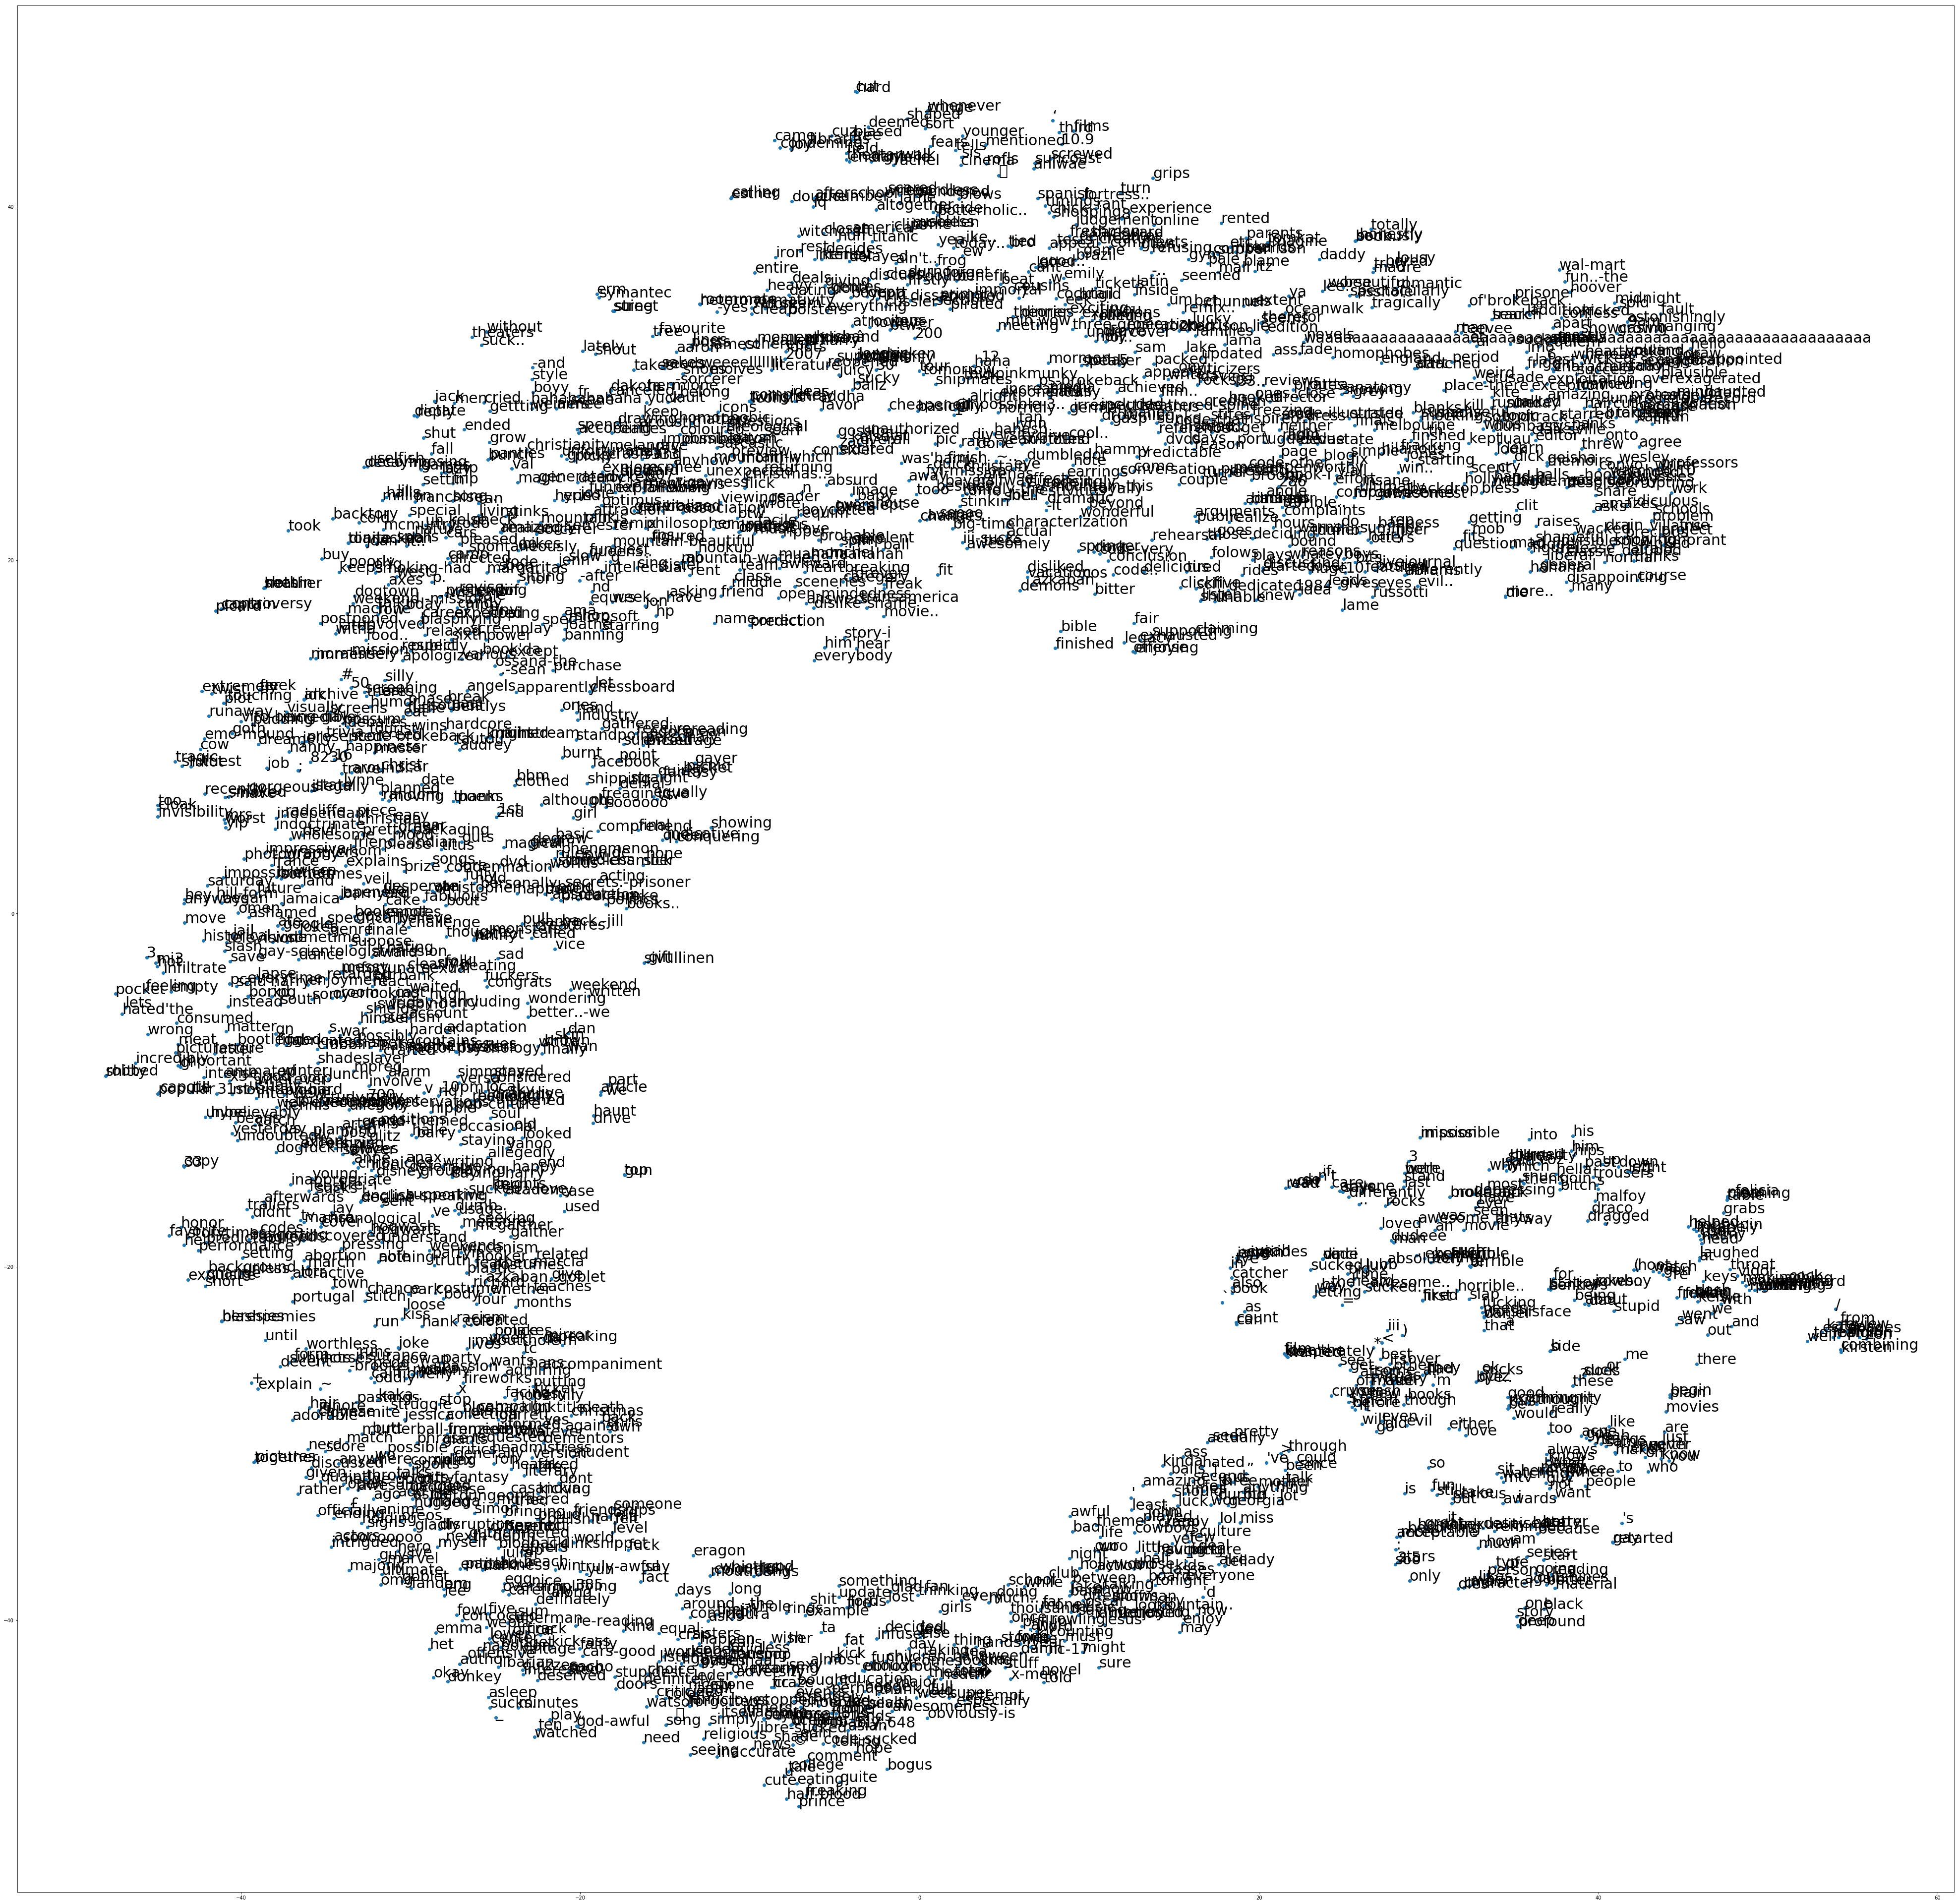

In [54]:
fig = plt.figure(figsize = (70, 70))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize = 30)
plt.show()

### Extracting Embedding Matrix

In [68]:
embedding_matrix = embed_model[embed_model.wv.vocab]
# vocabluray를 행렬 형태로 저장

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [69]:
embedding_matrix.shape

(2328, 128)

In [70]:
embed_model.wv.index2word
# index 순서대로 단어 출력

['i',
 ',',
 '.',
 'the',
 'and',
 '!',
 'harry',
 'vinci',
 'da',
 'brokeback',
 'code',
 'mountain',
 'potter',
 '...',
 'love',
 'is',
 'a',
 'was',
 'mission',
 'impossible',
 'awesome',
 'like',
 'it',
 'to',
 'movie',
 'that',
 "'s",
 'because',
 'sucks',
 'hate',
 'sucked',
 'so',
 'as',
 'my',
 '``',
 'much',
 'of',
 'really',
 'movies',
 'stupid',
 'you',
 'down',
 'we',
 'but',
 'be',
 'with',
 'just',
 'one',
 'potter..',
 'know',
 'suck',
 'out',
 '3',
 'who',
 'or',
 '/',
 'am',
 'loved',
 'want',
 'into',
 'which',
 'right',
 'for',
 'an',
 "n't",
 'this',
 'me',
 ':',
 'are',
 'think',
 'not',
 'how',
 'if',
 'depressing',
 'people',
 'his',
 'would',
 'up',
 'reading',
 'why',
 'series',
 'there',
 'in',
 'only',
 'fucking',
 'terrible',
 'she',
 'story',
 'oh',
 'being',
 '..',
 'left',
 'guy',
 'here',
 'ok',
 'start',
 'felicia',
 '(',
 'have',
 'book',
 'about',
 'beautiful',
 'good',
 'also',
 'too',
 'on',
 'do',
 'went',
 'read',
 'at',
 'can',
 'then',
 'saw',
 

#### Index2word / word2index from word2vec output

In [71]:
index2word = {i+1: w for i, w in enumerate(embed_model.wv.index2word)} # index와 단어를 매핑해 딕셔너리 형태로 생성
index2word[0] = 'PAD' # 시작을 표시
word2index = {w: i for i, w in index2word.items() } # 단어와 index를 매핑해 딕셔너리 형태로 생성

In [72]:
print("index2word")
print(index2word)

index2word
{0: 'PAD', 1: 'i', 2: ',', 3: '.', 4: 'the', 5: 'and', 6: '!', 7: 'harry', 8: 'vinci', 9: 'da', 10: 'brokeback', 11: 'code', 12: 'mountain', 13: 'potter', 14: '...', 15: 'love', 16: 'is', 17: 'a', 18: 'was', 19: 'mission', 20: 'impossible', 21: 'awesome', 22: 'like', 23: 'it', 24: 'to', 25: 'movie', 26: 'that', 27: "'s", 28: 'because', 29: 'sucks', 30: 'hate', 31: 'sucked', 32: 'so', 33: 'as', 34: 'my', 35: '``', 36: 'much', 37: 'of', 38: 'really', 39: 'movies', 40: 'stupid', 41: 'you', 42: 'down', 43: 'we', 44: 'but', 45: 'be', 46: 'with', 47: 'just', 48: 'one', 49: 'potter..', 50: 'know', 51: 'suck', 52: 'out', 53: '3', 54: 'who', 55: 'or', 56: '/', 57: 'am', 58: 'loved', 59: 'want', 60: 'into', 61: 'which', 62: 'right', 63: 'for', 64: 'an', 65: "n't", 66: 'this', 67: 'me', 68: ':', 69: 'are', 70: 'think', 71: 'not', 72: 'how', 73: 'if', 74: 'depressing', 75: 'people', 76: 'his', 77: 'would', 78: 'up', 79: 'reading', 80: 'why', 81: 'series', 82: 'there', 83: 'in', 84: 'onl

In [73]:
print("word2index")
print(word2index)

word2index
{'hookup': 968, 'symantec': 970, 'holy': 971, 'deep': 227, 'apart': 972, '.': 3, 'unfortunately': 2251, 'general': 974, 'comprehend': 1750, 'read': 109, 'clearly': 975, 'semester': 976, 'much..': 416, 'finish': 977, 'luau': 978, 'anyhow': 979, 'pretty': 313, 'catch': 649, 'realize': 2026, 'yet': 386, 'horrible..': 205, 'go': 322, 'silver': 981, 'liked': 121, 'magical': 982, 'ripping': 983, 'roommate': 984, 'cool..': 985, 'fabricated': 986, 'storytimes': 987, 'night': 367, 'music': 485, 'part': 486, 'dont': 535, 'week..-have': 988, 'knight': 989, 'crap': 448, 'starring': 1867, 'dumb..': 1684, 'spontaneously': 993, 'simple': 994, 'nothing': 536, 'frog': 995, 'tournament..': 2005, 'cars-good': 996, 'cowan': 997, 'nor': 651, 'leder': 998, 'hanks': 652, 'god': 419, 'slow': 999, 'question': 654, 'briefly': 2189, 'flick': 655, 'shields': 1000, 'sceneries': 1001, 'save': 1297, 'kick-ass': 1003, 'stuff': 551, 'christopher': 1004, 'literary': 1005, 'disappointed': 1006, 'emily': 1007,

### Keras를 통한 감성분석 모델 설계

#### set input & output

In [74]:
x = np.empty((n_lines, ), dtype=list)
y = np.zeros((n_lines, ))

#### generate sequence with word2index and map labels for each words

In [75]:
i = 0
train_file = open(os.path.join(data_path, "umich-sentiment-train.txt"), 'rb')

for line in train_file:
    label, sentence = line.decode('utf8').strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    x[i] = seqs
    y[i] = int(label)
    i += 1
train_file.close()
x = sequence.pad_sequences(x, maxlen = MAX_SENTENCE_LENGTH)

In [76]:
x.shape

(7086, 42)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5668, 42) (1418, 42) (5668,) (1418,)


In [78]:
len(sentences), x.shape

(7086, (7086, 42))

#### RNN model building and fitting with trained embedding matrix

In [97]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_SIZE, 
                    input_length = MAX_SENTENCE_LENGTH, 
                    weights = [embedding_matrix], 
                    mask_zero = True, trainable=False))
# Embedding은 모델의 맨 앞단에만 사용 가능
# mask_zero: 0을 zero padding으로 처리, 0 번째 index의 단어는 사용 불가능, RNN의 길이가 다른 것을 쌓을 때 유용
model.add(Dropout(0.2)) # embedding에 대한 dropout 확률 0.2로 설정
model.add(SimpleRNN(HIDDEN_LAYER_SIZE, recurrent_dropout = 0.2)) # RNN설정 
model.add(Dense(1)) # output이 positive와 negative 2개이므로 0 or 1이 나오게 layer 설정
model.add(Activation("sigmoid")) # output이 0과 1 이므로 0과 1사이의 값을 갖는 sigmoid를 activation function으로 사용
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", auc])
# 0과 1로 분류하므로 binary crossentropy사용
# 검증 메트릭은 위에 정의한 auc로 사용

In [98]:
model.summary() #텍스트로 모델 요약

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 42, 128)           297984    
_________________________________________________________________
dropout_4 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 310,401
Trainable params: 12,417
Non-trainable params: 297,984
_________________________________________________________________


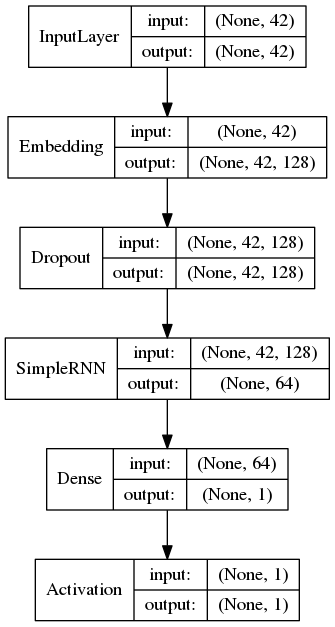

In [99]:
plot_model(model, show_shapes = True, show_layer_names = False) # plotdot 라이브러리와 graphviz 패키지를 사용한 도형으로 시각화
Image(filename = 'model.png')

### Training

In [100]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))#, callbacks=[tensorboard])
# 학습 수행

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.6615 - acc: 0.5849 - auc: 0.6207 - val_loss: 0.5797 - val_acc: 0.7137 - val_auc: 0.7753
Epoch 2/10
5668/5668 [==============================] - 1s 231us/step - loss: 0.5988 - acc: 0.6613 - auc: 0.7311 - val_loss: 0.5214 - val_acc: 0.7856 - val_auc: 0.8321
Epoch 3/10
5668/5668 [==============================] - 1s 242us/step - loss: 0.5549 - acc: 0.7225 - auc: 0.7898 - val_loss: 0.4759 - val_acc: 0.8096 - val_auc: 0.8687
Epoch 4/10
5668/5668 [==============================] - 1s 241us/step - loss: 0.5184 - acc: 0.7631 - auc: 0.8255 - val_loss: 0.4356 - val_acc: 0.7976 - val_auc: 0.8896
Epoch 5/10
5668/5668 [==============================] - 1s 239us/step - loss: 0.4948 - acc: 0.7782 - auc: 0.8418 - val_loss: 0.3975 - val_acc: 0.8244 - val_auc: 0.9037
Epoch 6/10
5668/5668 [==============================] - 1s 242us/step - loss: 0.4667 - acc: 0.7922 - auc: 0.8649 

### Evaluate the model

In [101]:
loss_test, acc_test, auc_test = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Test loss: %.3f, accuracy: %.3f, auc: %.3f" % (loss_test, acc_test, auc_test))

1418/1418 [==============================] - 0s 155us/step
Test loss: 0.333, accuracy: 0.869, auc: 0.935


#### Prediction for test sentences

In [102]:
for i in range(10):
    idx = np.random.randint(len(x_test))
    xtest = x_test[idx].reshape(1, 42)
    y_label = y_test[idx]
    y_pred = model.predict(x_test)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (y_pred, y_label, sent))

1	1	da vinci code was an awesome movie ...
1	0	da vinci code sucks be ...
1	0	ok brokeback mountain is such a horrible movie .
1	0	i officially * hate * brokeback mountain ! ! ! ! ! ! ! ! ! ! !
1	0	by the way , the da vinci code sucked , just letting you know ...
1	1	we 're gon na like watch mission impossible or hoot . (
1	1	because i would like to make friends who like the same things i like , and i really like harry potter , so i thought that joining a community like this would be a good start .
1	1	this was the first clive cussler i 've ever read , but even books like relic , and da vinci code were more plausible than this .
1	1	because i would like to make friends who like the same things i like , and i really like harry potter , so i thought that joining a community like this would be a good start .
1	1	and da vinci code is awesome .


#### LSTM model building and fitting with trained embedding matrix

In [103]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_SIZE, 
                    input_length = MAX_SENTENCE_LENGTH, 
                    weights = [embedding_matrix], 
                    mask_zero = True, trainable=False))
# Embedding은 모델의 맨 앞단에만 사용 가능
# mask_zero: 0을 zero padding으로 처리, 0 번째 index의 단어는 사용 불가능, RNN의 길이가 다른 것을 쌓을 때 유용
model.add(Dropout(0.2)) # embedding에 대한 dropout 확률 0.2로 설정
model.add(LSTM(HIDDEN_LAYER_SIZE, recurrent_dropout = 0.2)) # LSTM설정 
model.add(Dense(1)) # output이 positive와 negative 2개이므로 0 or 1이 나오게 layer 설정
model.add(Activation("sigmoid")) # output이 0과 1 이므로 0과 1사이의 값을 갖는 sigmoid를 activation function으로 사용
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", auc])
# 0과 1로 분류하므로 binary crossentropy사용
# 검증 메트릭은 위에 정의한 auc로 사용

In [104]:
model.summary() #텍스트로 모델 요약

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 42, 128)           297984    
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 347,457
Trainable params: 49,473
Non-trainable params: 297,984
_________________________________________________________________


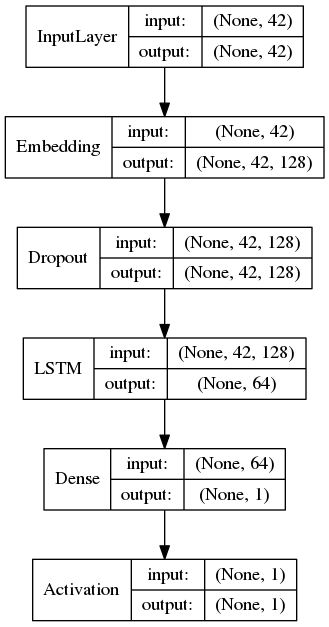

In [105]:
plot_model(model, show_shapes = True, show_layer_names = False) # plotdot 라이브러리와 graphviz 패키지를 사용한 도형으로 시각화
Image(filename = 'model.png')

### Training

In [106]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))#, callbacks=[tensorboard])
# 학습 수행

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 22s 4ms/step - loss: 0.6732 - acc: 0.5639 - auc: 0.5886 - val_loss: 0.6511 - val_acc: 0.5762 - val_auc: 0.6458
Epoch 2/10
5668/5668 [==============================] - 2s 360us/step - loss: 0.6264 - acc: 0.5894 - auc: 0.6868 - val_loss: 0.5738 - val_acc: 0.6403 - val_auc: 0.7375
Epoch 3/10
5668/5668 [==============================] - 2s 360us/step - loss: 0.5527 - acc: 0.6454 - auc: 0.7325 - val_loss: 0.5298 - val_acc: 0.6368 - val_auc: 0.7662
Epoch 4/10
5668/5668 [==============================] - 2s 355us/step - loss: 0.5300 - acc: 0.6685 - auc: 0.7630 - val_loss: 0.5142 - val_acc: 0.6791 - val_auc: 0.7830
Epoch 5/10
5668/5668 [==============================] - 2s 366us/step - loss: 0.5134 - acc: 0.7024 - auc: 0.7909 - val_loss: 0.5023 - val_acc: 0.6749 - val_auc: 0.8075
Epoch 6/10
5668/5668 [==============================] - 2s 360us/step - loss: 0.4982 - acc: 0.7281 - auc: 0.8240 

### Evaluate the model

In [107]:
loss_test, acc_test, auc_test = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Test loss: %.3f, accuracy: %.3f, auc: %.3f" % (loss_test, acc_test, auc_test))

1418/1418 [==============================] - 0s 180us/step
Test loss: 0.386, accuracy: 0.807, auc: 0.921


#### Prediction for test sentences

In [109]:
for i in range(10):
    idx = np.random.randint(len(x_test))
    xtest = x_test[idx].reshape(1, 42)
    y_label = y_test[idx]
    y_pred = model.predict(x_test)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (y_pred, y_label, sent))

1	1	da vinci code was an awesome movie ...
1	1	i love brokeback mountain ... .
1	1	brokeback mountain was an awesome movie .
1	1	i absolutely love harry potter , as you can tell already .
1	1	anyway , thats why i love `` brokeback mountain .
1	0	my dad 's being stupid about brokeback mountain ...
1	1	i am going to start reading the harry potter series again because that is one awesome story .
1	0	by the way , the da vinci code sucked , just letting you know ...
1	1	anyway , thats why i love `` brokeback mountain .
1	0	ok brokeback mountain is such a horrible movie .


#### GRU model building and fitting with trained embedding matrix

In [89]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_SIZE, 
                    input_length = MAX_SENTENCE_LENGTH, 
                    weights = [embedding_matrix], 
                    mask_zero = True, trainable=False))
# Embedding은 모델의 맨 앞단에만 사용 가능
# mask_zero: 0을 zero padding으로 처리, 0 번째 index의 단어는 사용 불가능, RNN의 길이가 다른 것을 쌓을 때 유용
model.add(Dropout(0.2)) # embedding에 대한 dropout 확률 0.2로 설정
model.add(GRU(HIDDEN_LAYER_SIZE, recurrent_dropout = 0.2)) # GRU설정 
model.add(Dense(1)) # output이 positive와 negative 2개이므로 0 or 1이 나오게 layer 설정
model.add(Activation("sigmoid")) # output이 0과 1 이므로 0과 1사이의 값을 갖는 sigmoid를 activation function으로 사용
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", auc])
# 0과 1로 분류하므로 binary crossentropy사용
# 검증 메트릭은 위에 정의한 auc로 사용

In [90]:
model.summary() #텍스트로 모델 요약

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 42, 128)           297984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 335,105
Trainable params: 37,121
Non-trainable params: 297,984
_________________________________________________________________


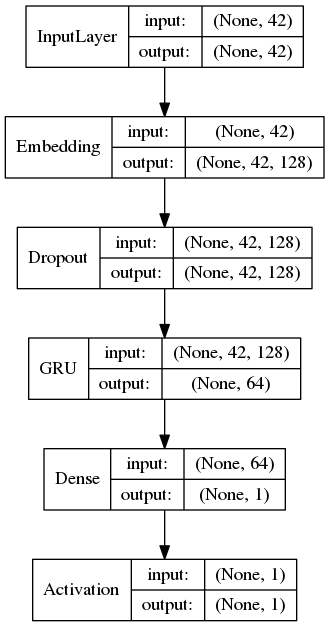

In [91]:
plot_model(model, show_shapes = True, show_layer_names = False) # plotdot 라이브러리와 graphviz 패키지를 사용한 도형으로 시각화
Image(filename = 'model.png')

### Training

In [92]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))#, callbacks=[tensorboard])
# 학습 수행

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 19s 3ms/step - loss: 0.6742 - acc: 0.5679 - auc: 0.6035 - val_loss: 0.6495 - val_acc: 0.5853 - val_auc: 0.6704
Epoch 2/10
5668/5668 [==============================] - 2s 323us/step - loss: 0.6367 - acc: 0.6087 - auc: 0.6796 - val_loss: 0.6071 - val_acc: 0.6283 - val_auc: 0.6962
Epoch 3/10
5668/5668 [==============================] - 2s 325us/step - loss: 0.5924 - acc: 0.6291 - auc: 0.7085 - val_loss: 0.5505 - val_acc: 0.6559 - val_auc: 0.7383
Epoch 4/10
5668/5668 [==============================] - 2s 323us/step - loss: 0.5362 - acc: 0.6604 - auc: 0.7520 - val_loss: 0.4984 - val_acc: 0.6707 - val_auc: 0.7943
Epoch 5/10
5668/5668 [==============================] - 2s 332us/step - loss: 0.4996 - acc: 0.7073 - auc: 0.8042 - val_loss: 0.4711 - val_acc: 0.7257 - val_auc: 0.8545
Epoch 6/10
5668/5668 [==============================] - 2s 325us/step - loss: 0.4741 - acc: 0.7414 - auc: 0.8511 

### Evaluate the model

In [93]:
loss_test, acc_test, auc_test = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Test loss: %.3f, accuracy: %.3f, auc: %.3f" % (loss_test, acc_test, auc_test))

1418/1418 [==============================] - 0s 173us/step
Test loss: 0.330, accuracy: 0.829, auc: 0.941


#### Prediction for test sentences

In [95]:
for i in range(10):
    idx = np.random.randint(len(x_test))
    xtest = x_test[idx].reshape(1, 42)
    y_label = y_test[idx]
    y_pred = model.predict(x_test)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (y_pred, y_label, sent))

1	1	i wanted desperately to love'the da vinci code as a film .
1	1	mission impossible 3 was excellent .
1	1	i love brokeback mountain ... .
1	1	the people who are worth it know how much i love the da vinci code .
1	0	harry potter dragged draco malfoy ’ s trousers down past his hips and sucked him into his throat with vigor , making whimpering noises and panting and groaning around the blonds rock-hard , aching cock ...
1	1	and as much as i want to despise tom and his scientology crusade , i still love mission impossible movies ...
1	0	i have to say , i hated brokeback mountain , though .
1	1	the people who are worth it know how much i love the da vinci code .
1	0	and i hate harry potter.. -- jame .
1	1	i either love brokeback mountain or think it 's great that homosexuality is becoming more acceptable ! :
